# JPMorgan (JPM) Closing Price Predictions

In this jupyter notebook I use machine learning to try and predict the closing price of JPM stock with the daily High, Low, Open, and Volume metrics as inputs. The model looks at the previous 15 days of these metrics and trys to predict the closing price of the 16th day. You are more than welcome to change the lookback period, but I have found that 15 days works pretty well. You can also change the JPM stock to any stock dataset you want, I just chose JPM as an example. The dataset is the daily metrics of JPM over the last 10 years and I got the dataset from the following [Link](https://finance.yahoo.com/quote/JPM/history?period1=1374451200&period2=1689984000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

<u>Our model works pretty well with a brief overview of the metrics here:</u>
- On average the model's predictions will be off by 1.42% of the true closing price
- 75% of the time our model's prediciton will be within 2.29% of the true closing price 
- 96.81% of the time our model's prediction will be within 5% of the true closing price

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sympy import divisors

In [2]:
csv_name = 'JPM_ten_years.csv'
df = pd.read_csv(csv_name)
print(df.head(5))

features = ['Open', 'High', 'Low', 'Volume'] 
target = 'Close'

         Date       Open       High        Low      Close  Adj Close    Volume
0  2013-07-22  56.169998  56.669998  55.950001  56.560001  42.783417  15999700
1  2013-07-23  56.720001  56.889999  56.470001  56.669998  42.866611  10577100
2  2013-07-24  56.919998  56.930000  56.380001  56.630001  42.836361  16665000
3  2013-07-25  56.450001  56.500000  55.889999  56.500000  42.738033  13870200
4  2013-07-26  56.060001  56.220001  55.599998  56.049999  42.397629  16762300


* I decided not to include the 'Adj Close' input as this value is calculated using the closing price.

### Scaling the dataset

We first need to scale the dataset using the MinMaxScaler from sklearn so all values in the dataset fall between 0 and 1. This is important because it helps improve the stability of the model because large values and small values get scaled accordingly. For example, the 'Volume' attribute in our dataset is much greater than the Open, High, and Low. If we did not scale the data, the 'Volume' attribute may weigh into the model predictions to much and lead to unstable training and predictions.

In [3]:
dataset = df[features + [target]].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

X = scaled_data[:, :-1]
y = scaled_data[:, -1]

### Set up for training

The model we are describing in this notebook will look at the previous 15 days of JPM metrics to make its prediction for the 16th. This can be changed if you want to be more days or less days, but from the testing that I have done, 15 days seems to work pretty well. 

In [4]:
lookback = 15 # We will look at the previous 15 days and try to predict the 16 day

X_seq, y_seq = [], []
for i in range(lookback, len(X)):
    X_seq.append(X[i - lookback:i])
    y_seq.append(y[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Model Arcitecture

If you don't know much about how neural networks work, or you don't feel like reading this, you can skip this part. Just know that we need to use a special type of neural network called an LSTM in order for this to work properly 🎸
<img src="LSTM_image.png" alt="Image" width="300" height="200">


The shape of this model is 50x50x50x1 where each layer of 50 is an LSTM layer and the final ouput layer is a dense layer. LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that doesn't suffer from the vanshish gradient problem.


What is the vanishing gradient problem? The vanishing gradient problem in summary is a challenge that arises in the training of deep neural networks where the gradient of the loss function becomes super small (effectively zero) which can lead to your model missing out on deep complex patterns. The cause of this problem is fundamental to backpropegation, as the problem arrises from the chain rule. As a reminder from calculus, the chain rule is $\frac{{df}}{{dx}} = \frac{{dy}}{{du}} * \frac{{du}}{{dx}}$ or better known as $f(g(x))' = f'(g(x)) * g'(x)$. Because many gradients have values a range between 0 and 1, and each time we compute the chain rule we are multiplying these values together getting smaller and smaller values until it... vanishes 😐->😶‍🌫️. If you want to learn more, read about it [here](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) or watch this [video](https://www.youtube.com/watch?v=qhXZsFVxGKo)

In summary LSTMs can overcome this vanishing gradient problem by using specialized memory cells and gating mechanisms (input, output, and forget gates). During each time step, the input gate controls the flow of new information into the memory cell, the forget gate determines what information to discard from the cell's memory given the new information that entered, and the output gate regulates the information to be passed to the next step. The chain rule remains intact in LSTMs, but the LSTM's forget gate allows the network to better control the gradients values at each time step which alleviates the vanishing gradient problem allowing for more effective training and capturing of complex sequential patterns in data. I HIGHLY suggest watching [this video](https://www.youtube.com/watch?v=YCzL96nL7j0) to get a better understanding because it helped me a lot. If you care more about the math behind LSTMs and their gradients I reccomend reading [this](https://medium.datadriveninvestor.com/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577#:~:text=LSTMs%20solve%20the%20problem%20using,step%20of%20the%20learning%20process.) but you need to be pretty mathmatically literate to read it.

In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
model.fit(X_train, y_train, epochs=80, batch_size=64)
data_name = csv_name.split(".")[0]
model.save(f'{lookback}_lookback_{data_name}.h5')
print(f"Model saved as: {lookback}_lookback_{data_name}.h5")

Epoch 1/80
32/32 [==============================] - 5s 29ms/step - loss: 0.0267
Epoch 2/80
32/32 [==============================] - 1s 28ms/step - loss: 0.0016
Epoch 3/80
32/32 [==============================] - 1s 28ms/step - loss: 0.0013
Epoch 4/80
32/32 [==============================] - 1s 28ms/step - loss: 0.0011
Epoch 5/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0011
Epoch 6/80
32/32 [==============================] - 1s 26ms/step - loss: 0.0011
Epoch 7/80
32/32 [==============================] - 1s 26ms/step - loss: 9.9738e-04
Epoch 8/80
32/32 [==============================] - 1s 26ms/step - loss: 9.9308e-04
Epoch 9/80
32/32 [==============================] - 1s 27ms/step - loss: 9.1251e-04
Epoch 10/80
32/32 [==============================] - 1s 29ms/step - loss: 0.0010
Epoch 11/80
32/32 [==============================] - 1s 27ms/step - loss: 9.4911e-04
Epoch 12/80
32/32 [==============================] - 1s 25ms/step - loss: 8.1255e-04
Epoch 13/80
32/32

In [18]:
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)

16/16 [==============================] - 0s 8ms/step - loss: 5.6095e-04
Train Loss: 0.00026399988564662635
Test Loss: 0.0005609505460597575


# Plotting our Results

16/16 [==============================] - 0s 8ms/step


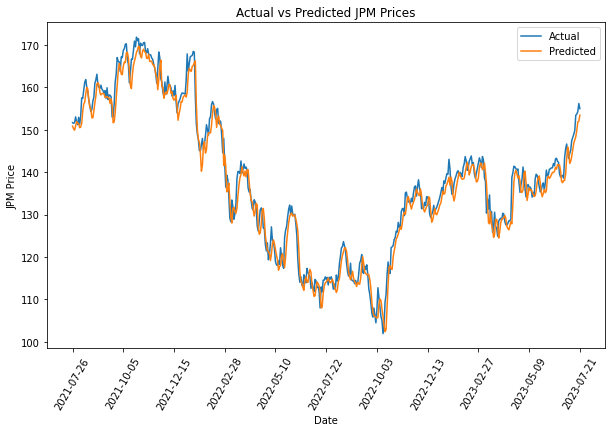

In [24]:
# Un-scale our predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(dataset[:, -1].reshape(-1, 1))

y_train_pred = target_scaler.inverse_transform(y_train_pred)
y_test_pred = target_scaler.inverse_transform(y_test_pred)

y_train_actual = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))


#Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates_test, y_test_actual, label='Actual')
plt.plot(dates_test, y_test_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('JPM Price')
plt.title('Actual vs Predicted JPM Prices')
plt.legend()

dates_test = df.iloc[-1 * len(y_test):]['Date']
divs = divisors(dates_test.shape[0] - 1 if dates_test.shape[0] % 2 else dates_test.shape[0] - 2)
tick_amount = divs[len(divs)//2 + 1]
plt.xticks(dates_test[::tick_amount], dates_test[::tick_amount], rotation=60) 
plt.show()

As you can see our model *appears* to work pretty well! The plot of the actual line is close to the predicted line suggesting that our predictions are good. But how accurate is our model *really*?

# How Accurate is Our Model

The general notion of accuracy falls short of correctly measuring model performance because of floating point arithmetic and how values like 130.2 and 130.1 are not equal. Because of this, we must employ other methods of determining accuracy thats better acustom to how close our model can predict the closing price.

In order to more accurately determine the model'd performance, I chose to calculate how close our predicted closing price is to the actual closing price. In order to do this we perform calculate the percent difference between the prediction and actual prices in the following way $\frac{|prediction - actual|}{actual}$. We take this percent difference for each testing example and make a histogram of all percent differences to see how they are distributed.

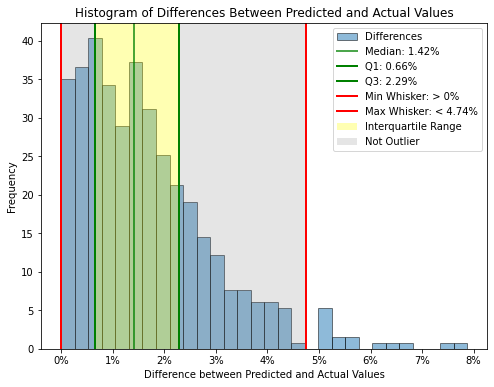

Percent of predictions within box plot: 96.81%


In [41]:
differences = np.abs(y_test_pred - y_test_actual) / y_test_actual

# Plot the histogram
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(differences, bins=30, edgecolor='black', alpha=0.5, density=True, label='Differences')

med = np.median(differences)
q1 = np.percentile(differences, 25)
q3 = np.percentile(differences, 75)
iqr = q3 - q1
min_whisker = 0 if q1 - (1.5 * iqr) < 0 else q1 - (1.5 * iqr)
max_whisker = q3 + (1.5 * iqr)

# Overlay the box plot
plt.axvline(med, color='green', linestyle='-', linewidth=2, label=f'Median: {round(med * 100, 2)}%', alpha=0.7)
plt.axvline(q1, color='green', linestyle='-', linewidth=2, label=f'Q1: {round(q1 * 100,2)}%')
plt.axvline(q3, color='green', linestyle='-', linewidth=2, label=f'Q3: {round(q3 * 100, 2)}%')
plt.axvline(min_whisker, color='red', linestyle='-', linewidth=2, label=f'Min Whisker: > {round(min_whisker * 100, 2)}%')
plt.axvline(max_whisker, color='red', linestyle='-', linewidth=2, label=f'Max Whisker: < {round(max_whisker * 100, 2)}%')


#Shading to show box plot stuff better
plt.axvspan(q1, q3, facecolor='yellow', alpha=0.3, label='Interquartile Range')
plt.axvspan(min_whisker, q1, facecolor='grey', alpha=0.2, label = 'Not Outlier')
plt.axvspan(q3, max_whisker, facecolor='grey', alpha=0.2)

plt.xlabel('Difference between Predicted and Actual Values')
plt.ylabel('Frequency')
plt.title('Histogram of Differences Between Predicted and Actual Values')
percent_formatter = mtick.PercentFormatter(xmax=1.0, decimals=0)
plt.gca().xaxis.set_major_formatter(percent_formatter)
plt.legend()
plt.show()

less_than_5_percent = differences[differences < max_whisker]
print(f'Percent of predictions within box plot: {round(len(less_than_5_percent)/len(differences)*100,2)}%')

From what we can see from this histogram, it appears to be positively skewed. Because of this skew, I opted to use a box and whisker plot rather than standard deviations to determine the distribution of results. I overlayed the box and whisker plot on the histogram to better display how the data is distributed per quartile. Recall that between each quartile is 25% of the data, and that all points beyond the Max Whisker or below the Min Whisker are considered outliers.

<u>The infromation for this box and whisker plot is as follows:</u>
- Minimum Whisker: 0%
- 1st Quartile: 0.66%
- Median: 1.42%
- 3rd Quartile: 2.29%
- Maximum Whisker: 4.74%

The median of the percent error distribution is 1.42% which means on average, the guesses were around 1.42% off from the actual prices. This is a very good result as 1.42% is small suggesting that our model on average makes good predictions. But averages aren't everything, so lets look further into the data.

The third quartile is located at 2.29% meaning that we can expect our predictions to be off by less than 2.29%, 75% of the time. This is also very good! 2.29% percent error is rather small which suggests that our model can consistently make accurate predictions. But still this isn't everything, lets look to see the worst case senario for our model

Our max whisker is located at 4.47% meaning that values beyond this mark are outliers. In fact, 96.81% of the predictions fall within 5% of the true closing price. This suggests that we can say with 96% confidence that our model will be within 5% of the true closing price. This is pretty epic. Nonetheless, it is important to note that even though it is very likely to be within 5%, it isn't gaurentee as our distribution has multiple outliers above 5% some even reaching above 7.5%. However these values are to be expected given that our data set isn't small and outliers will find their way into data sets one way or another.
 

<u>Overall the model performs well. The key take aways are the following:</u>
- On average the models predictions will be off by 1.42% of the true closing price
- 75% of the time our model's prediciton will be within 2.29% of the true closing price 
- 96.81% of the time our model's prediction will be within 5% of the true closing price